# RQ1 - "Is discussion led by the core community, or by external visitors?"

In this notebook, we will attempt to answer our first research question.
We would like to know if the discussion on the forum is primarily led by regular, dedicated members, or by visitors from outside.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.insert(1, "../")
sys.path.insert(1, "../utilities")

from group_analysis import do_kmeans_clustering, plot_clusters, log_and_scale, colour_list
from helpers import load_posts, load_toks

from settings import TFES_FP as DB_FP, TFES_TOK_FP, DATA_DIR
# ACE_FP = "../data/metagroups_ace_comparison.json"
ACE_FP = os.path.join(DATA_DIR, "Misc", "metagroups_ace_chunked_15K_bal.json")
OUT_DIR = "./Graphs"

linestyle_list = ["-", "--", ":"]

## Part One: Looking at Metastatistics

The first step is to look at the meta-information in the corpus, and trying to see whether the majority of posts are by those who frequently contribute, or by outsiders.

Below we will grab all the posts.

In [2]:
%%time
all_posts = load_posts(DB_FP)

from helpers import flat_earth_boards, off_topic_boards as other_boards

posts = all_posts.query("board_id in @flat_earth_boards")

toks = {x[0]: x[1] for x in load_toks(TFES_TOK_FP)}
toks = pd.Series(toks)

Wall time: 15.5 s


Then we will get three basic meta-statistics for users: number of posts, number of boards posted in, and number of days on the forum.

In [3]:
%%time
all_users = [u for u in posts["poster_id"].unique() if not np.isnan(u)]

def find_first_and_last(curr_posts):
    curr_posts = curr_posts.sort_values("time", ascending=True)
    return (curr_posts["time"].iloc[0], curr_posts["time"].iloc[-1])

first_and_last = posts.groupby("poster_id").apply(find_first_and_last)

user_lifetimes = first_and_last.apply(lambda x: (x[1] - x[0]).days + 1)

posts_per_user = posts.groupby("poster_id").size()
user_n_posts_per_board = posts.groupby("poster_id").apply(lambda x: x.groupby("board_id").size()).unstack(level=1).fillna(0)
boards_per_user = user_n_posts_per_board.apply(lambda x: len(x[x>0]), axis=1)

feats = pd.DataFrame(index=posts_per_user.index)
feats["posts"] = posts_per_user
feats["boards"] = boards_per_user
feats["lifetime"] = user_lifetimes

Wall time: 1.78 s


Now we cluster these meta-stats using kmeans clustering to make 3 groups.

In [4]:
%%time
meta_clusts, meta_clust_centres = do_kmeans_clustering(feats.values, 3, 1234, True, True)

Wall time: 52.5 ms


Write these clusters to a file so we can run ACE analysis later.

In [5]:
# Comment this out and make clust_names = None if you don't want any
clust_names = ["Ephemeral Visitors", "The Middle", "Core Community"]
named_metaclusts = np.array([clust_names[c] for c in meta_clusts])
named_centres = {clust_names[i]: meta_clust_centres[i] for i in range(len(meta_clust_centres))}
clust_colours = {clust: colour_list[i] for i, clust in enumerate(set(named_metaclusts))}
clust_linestyles = {clust: linestyle_list[i] for i, clust in enumerate(set(named_metaclusts))}
nice_name_column_dict = {"posts": "Num Posts", "boards": "Num Boards", "lifetime": "Num Days"}

In [6]:
import json
# Writing the indexes of posts in each group
clust_posts = {clust: list(posts[posts.poster_id.isin(feats[named_metaclusts==clust].index)].index) for clust in clust_names}
with open("../data/metagroups.json", "w") as group_file:
    json.dump(clust_posts, group_file)
    
with open("../data/user_metagroup.json", "w") as group_file:
    json.dump({u: c for u, c in zip(feats.index, named_metaclusts)}, group_file)

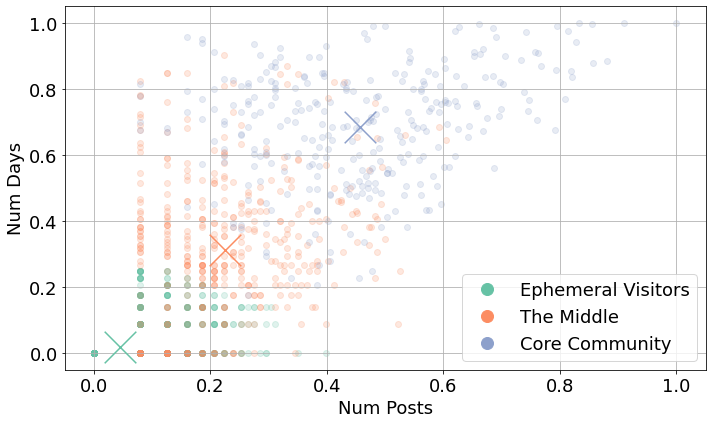

In [7]:
import matplotlib.lines as mlines
log_scaled = log_and_scale(feats.values, True, True)
fig, ax = plot_clusters(log_scaled[:, [0,2]], named_metaclusts, {c: v[[0, 2]] for c, v in named_centres.items()})
ax.set_xlabel(nice_name_column_dict[feats.columns[0]], fontsize=18)
ax.set_ylabel(nice_name_column_dict[feats.columns[2]], fontsize=18)
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
ax.grid()

curr_colours = {clust: colour_list[i] for i, clust in enumerate(set(named_metaclusts))}
plt.legend(handles=[mlines.Line2D([], [], color=curr_colours[curr_clust], marker='o', linestyle='None',
                                  markersize=12, label=curr_clust) 
                    for curr_clust in clust_names], fontsize=18)

plt.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "Clust_Scatter.pdf"))
plt.show()

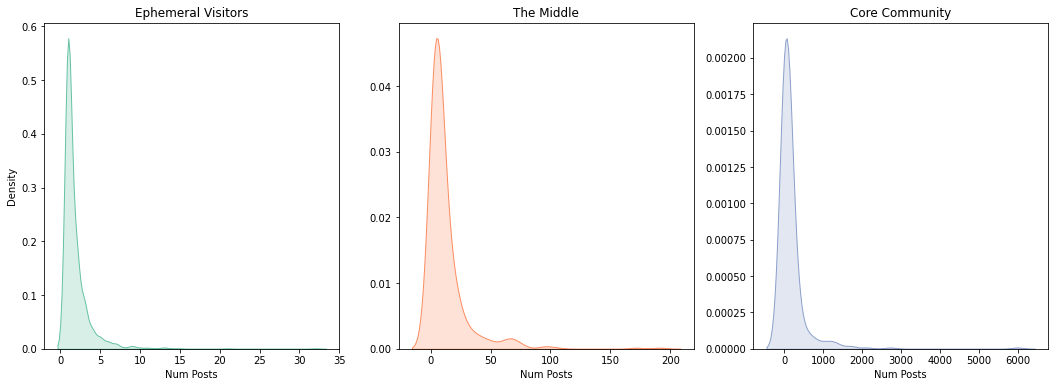

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, clust in enumerate(clust_names):
    sns.kdeplot(feats[named_metaclusts==clust]["posts"], ax=axes[i], fill=True, 
                color=clust_colours[clust], label=clust)
    axes[i].set_title(clust)
    axes[i].set_xlabel("Num Posts")
    axes[i].set_ylabel("")
    
axes[0].set_ylabel("Density")
plt.show()

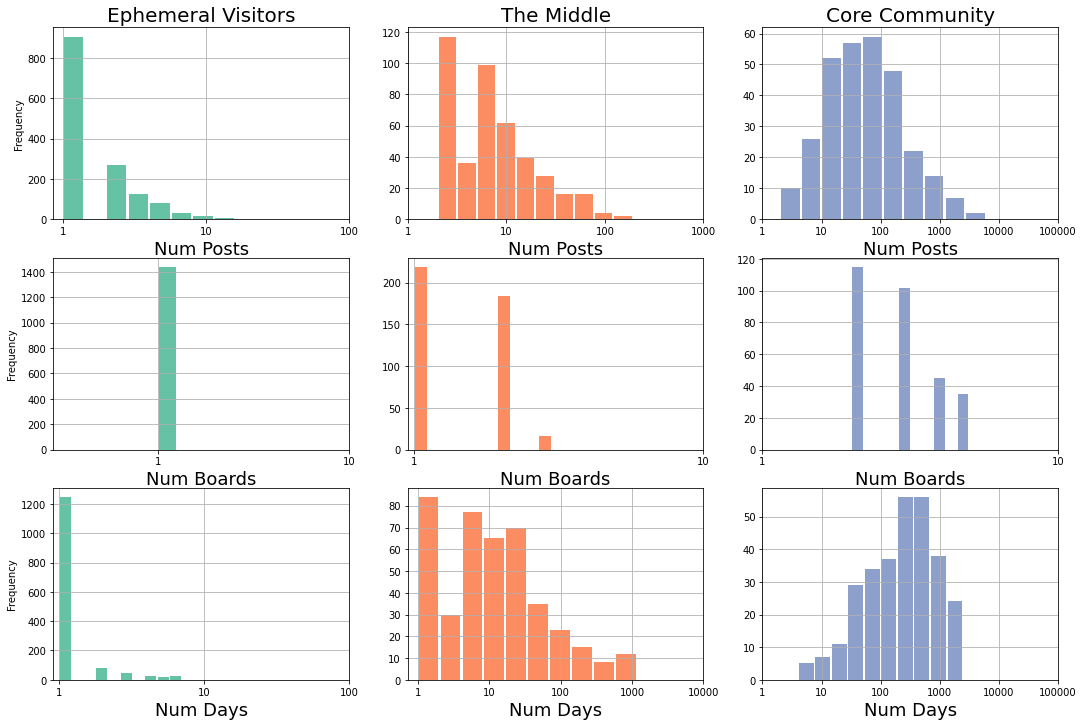

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
for i, column in enumerate(feats.columns):
    for j, clust in enumerate(clust_names):
        cur_logged_values = feats[named_metaclusts==clust][column].apply(np.log10)
        cur_logged_values.plot.hist(grid=True, bins=10, rwidth=0.9, ax=axes[i, j], color=clust_colours[clust], label=clust)
        axes[i, j].set_xticks(list(range(0, int(axes[i, j].get_xticks()[-1])+2)))
        axes[i, j].set_xticklabels([10**x for x in axes[i, j].get_xticks()])
        axes[i, j].set_xlabel(nice_name_column_dict[column], fontsize=18)
        axes[i, j].set_ylabel("")
    
    axes[i, 0].set_ylabel("Frequency")

for i, clust in enumerate(clust_names):
    axes[0, i].set_title(clust, fontsize=20)

plt.show()

In [10]:
feats.groupby(named_metaclusts).mean().loc[clust_names]

,posts,boards,lifetime
Ephemeral Visitors,1.869535,1.000000,1.307425
The Middle,12.560859,1.515513,52.980907
Core Community,180.390572,3.000000,457.659933


In [11]:
feats.groupby(named_metaclusts).median().loc[clust_names]

,posts,boards,lifetime
Ephemeral Visitors,1,1,1
The Middle,6,1,11
Core Community,52,3,246


In [12]:
feats.groupby(named_metaclusts).max().loc[clust_names]

,posts,boards,lifetime
Ephemeral Visitors,32,1,7
The Middle,191,3,1166
Core Community,5983,5,2502


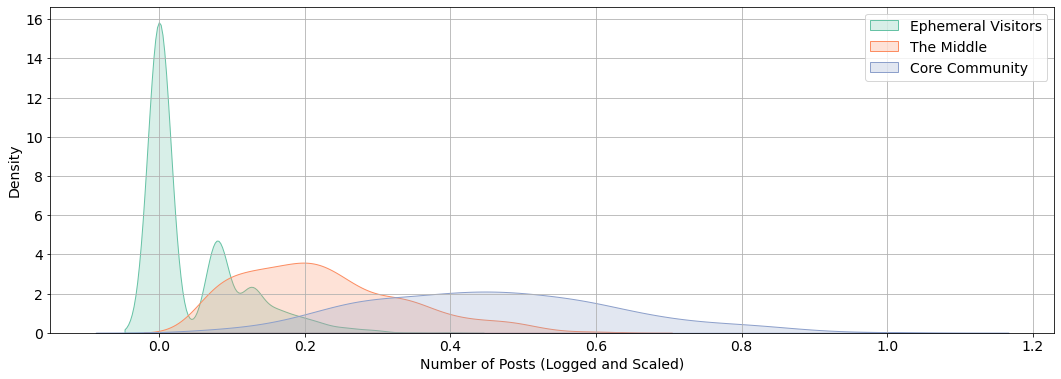

In [13]:
fig, ax = plt.subplots(figsize=(18, 6))
for clust in clust_names:
    sns.kdeplot(log_scaled[named_metaclusts==clust][:, 0], ax=ax, fill=True, 
                color=clust_colours[clust], label=clust)
ax.legend()
ax.set_xlabel("Number of Posts (Logged and Scaled)", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.grid()
ax.legend(fontsize=14)


fig.savefig(os.path.join(OUT_DIR, "num_posts_density.pdf"))
plt.show()

In [14]:
[clust_colours[n] for n in clust_names]

['#66c2a5', '#fc8d62', '#8da0cb']

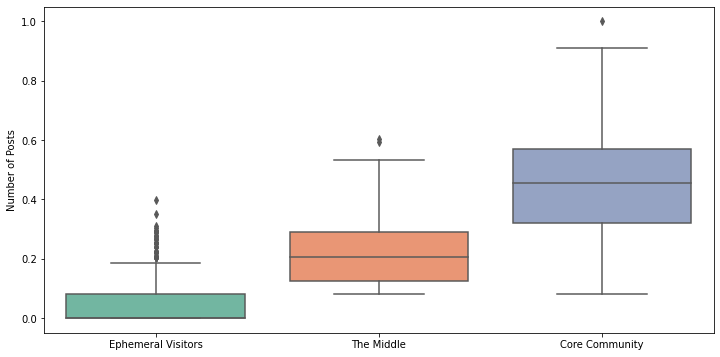

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
data = [log_scaled[named_metaclusts==clust][:, 0] for clust in clust_names]
sns.boxplot(data=data, ax=ax, palette=[clust_colours[n] for n in clust_names])
# ax.set_xlabel("Cluster")
ax.set_ylabel("Number of Posts")
ax.set_xticklabels(clust_names)
plt.show()

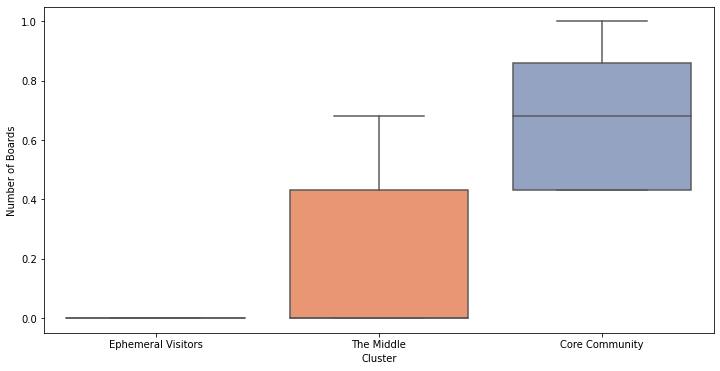

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
data = [log_scaled[named_metaclusts==clust][:, 1] for clust in clust_names]
sns.boxplot(data=data, ax=ax, palette=[clust_colours[n] for n in clust_names])
ax.set_xlabel("Cluster")
ax.set_ylabel("Number of Boards")
ax.set_xticklabels(clust_names)
plt.show()

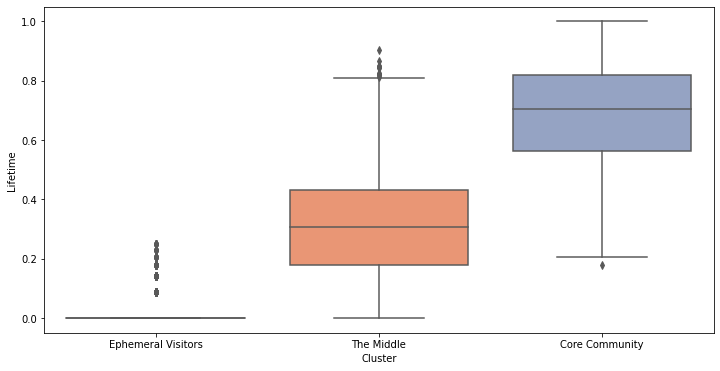

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
data = [log_scaled[named_metaclusts==clust][:, 2] for clust in clust_names]
sns.boxplot(data=data, ax=ax, palette=[clust_colours[n] for n in clust_names])
ax.set_xlabel("Cluster")
ax.set_ylabel("Lifetime")
ax.set_xticklabels(clust_names)
plt.show()

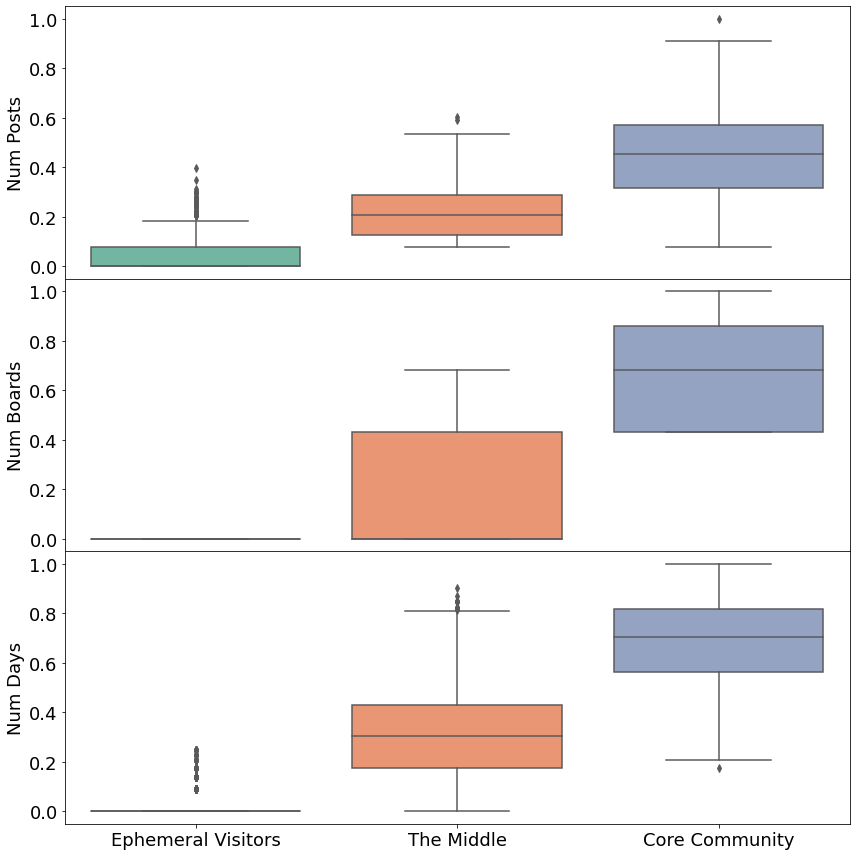

In [18]:
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(log_scaled.shape[1], hspace=0)
axes = gs.subplots(sharex=True)

for i, feat_name in enumerate(feats.columns):
    data = [log_scaled[named_metaclusts==clust][:, i] for clust in clust_names]
    sns.boxplot(data=data, ax=axes[i], palette=[clust_colours[n] for n in clust_names])
    axes[i].set_ylabel(nice_name_column_dict[feat_name], fontsize=18)
    axes[i].tick_params(axis='y', which='major', labelsize=18)
    
axes[-1].set_xticklabels(clust_names, fontsize=18)
plt.tight_layout()

fig.savefig(os.path.join(OUT_DIR, "meta_box_plots.pdf"))
    
plt.show()

#### Plotting posts over time for each group

In [19]:
clust_posts = {clust: posts[posts.poster_id.isin(feats[named_metaclusts==clust].index)].index for clust in clust_names}

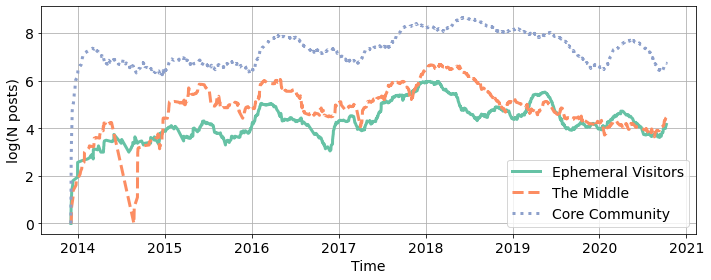

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))

for clust, curr_posts in clust_posts.items():
    curr_posts = posts.loc[curr_posts]
    curr_posts.loc[:, "flag"] = [True] * len(curr_posts)
    rolling_post_counts = curr_posts.rolling("90D", on="time").count()["flag"].apply(np.log)
    ax.plot(curr_posts["time"], rolling_post_counts.values, 
            color=clust_colours[clust], 
            ls=clust_linestyles[clust], lw=3, label=clust)
    
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("log(N posts)", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.grid()
ax.legend(fontsize=14)
plt.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "metagroups_over_time.pdf"))
plt.show()

## Part Two: Looking at differences between the groups

Next we will look at the differences in language between these groups.
Are certain words or phrases over used by the community compared to visitors?

In [21]:
feats[meta_clusts==1].index

Float64Index([   6.0,   10.0,   12.0,   54.0,   56.0,   73.0,   79.0,   82.0,
                89.0,   90.0,
              ...
              2263.0, 2264.0, 2269.0, 2277.0, 2283.0, 2286.0, 2291.0, 2294.0,
              2299.0, 2308.0],
             dtype='float64', name='poster_id', length=419)

In [22]:
{clust: posts[posts.poster_id.isin(feats[named_metaclusts==clust].index)].index for clust in clust_names}

{'Ephemeral Visitors': Int64Index([   192,    297,    787,   1044,   1970,   2082,   4196,   4198,
               4200,   4249,
             ...
             126062, 126085, 126101, 126108, 126135, 126156, 126166, 126170,
             126180, 126185],
            dtype='int64', name='uid', length=2694),
 'The Middle': Int64Index([   406,    870,   2179,   2264,   3763,   3830,   4522,   4904,
               5040,   5471,
             ...
             126046, 126073, 126077, 126123, 126131, 126150, 126168, 126192,
             126195, 126199],
            dtype='int64', name='uid', length=5263),
 'Core Community': Int64Index([    40,    195,    198,    203,    298,    299,    301,    340,
                342,    351,
             ...
             126178, 126181, 126182, 126183, 126187, 126188, 126193, 126194,
             126196, 126200],
            dtype='int64', name='uid', length=53576)}

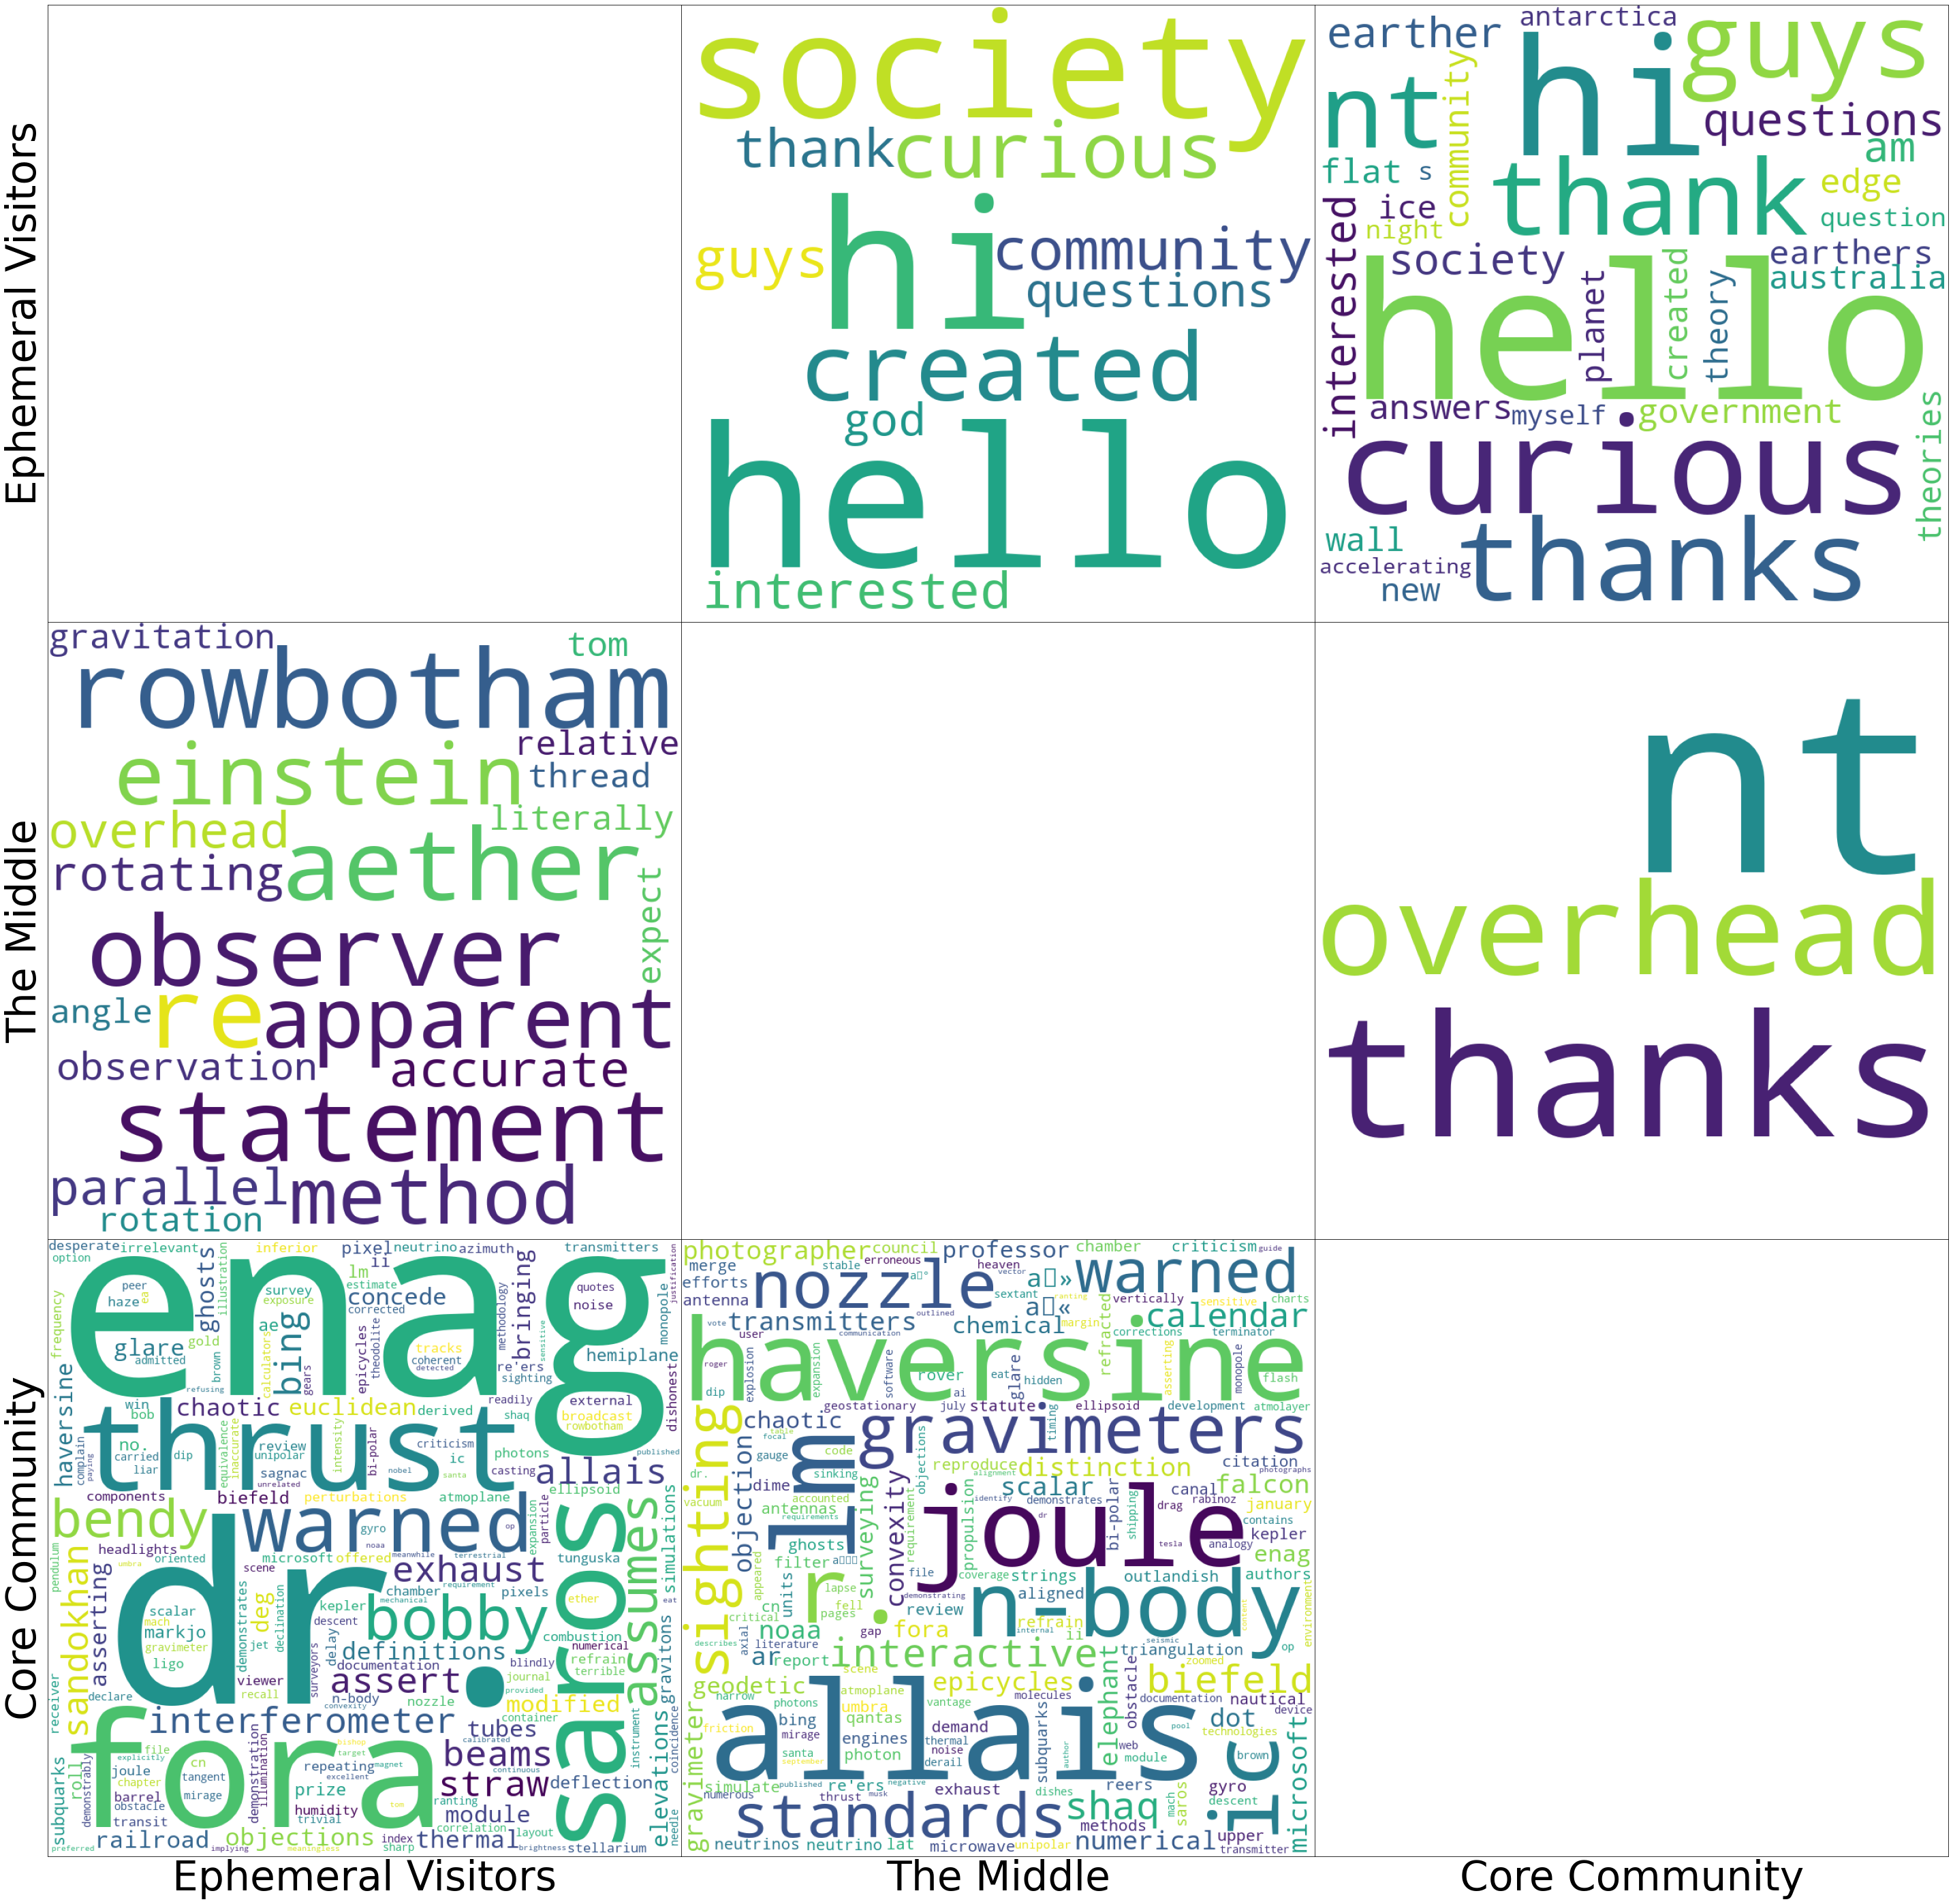

Wall time: 29.9 s


In [23]:
%%time
from group_analysis import get_inter_group_kw, display_group_kw_combis
# Don't do this in a list comprehension. It's disgusting.
clust_kw = get_inter_group_kw({clust: posts[posts.poster_id.isin(feats[named_metaclusts==clust].index)].index for clust in clust_names}, toks, 1)
# clust_kw_lr = {i1: {i2: cell.query("LL > 3.84 and LR > 1 and freq1 > 100")["LR"] for i2, cell in row.items()} for i1, row in clust_kw.items()}
clust_kw_lr = {i1: {i2: cell.query("LR > 1 and freq1 > 100")["LR"] for i2, cell in row.items()} for i1, row in clust_kw.items()}
fig = display_group_kw_combis(clust_kw_lr)
fig.savefig(os.path.join(OUT_DIR, "Cluster_Keywords.pdf"))
plt.show()

## Part Three: Comparing the language models of these groups over time

Now we've looked at them a bit more, we will look at the ACE of the two groups over time, compared to both the general forum, and each other.

In [24]:
ACE_FP = os.path.join(DATA_DIR, "Misc", "ace_metagroups.json")

In [25]:
from language_change_methods.cross_entropy import get_CE_comparisons, get_ends_of_windows
from language_change_methods.cross_entropy_sampling import get_ce_mean_and_std, plot_group_similarity_across_runs_simple, plot_group_similarity_across_runs_stepped, get_CE_means_fixed_windows
from language_change_methods.analysis_functions import get_significant_windows, plot_hlines, highlight_significant_windows, highlight_significant_changes

In [26]:
comparisons = get_CE_comparisons(ACE_FP)
end_dates = get_ends_of_windows(ACE_FP)
groups = list(comparisons[0].keys())

In [27]:
groups = ["Core Community", "Ephemeral Visitors"]

### Unpredictability of each group

First we will look at the unpredictability of each group.

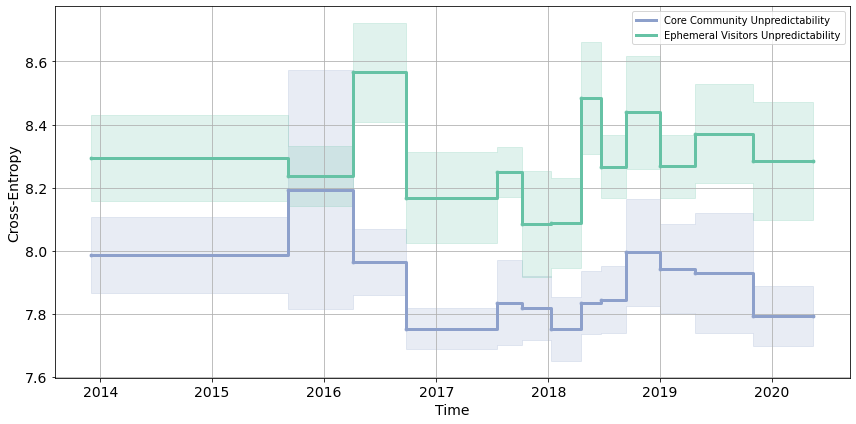

Wall time: 284 ms


In [28]:
%%time
fig, ax = plt.subplots(figsize=(12, 6))
fig.subplots_adjust(hspace=0, wspace=0)

for group in groups:
    unpredictability_runs = get_CE_means_fixed_windows(comparisons, group, group)
    unpredictability_means, unpredictability_stds = get_ce_mean_and_std(comparisons, group, group)
    
    plot_group_similarity_across_runs_stepped(unpredictability_means, unpredictability_stds, 
                                          ax, colour=clust_colours[group], label=f'{group} Unpredictability', 
                                          fill_alpha=0.2, end_dates=end_dates)
    
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Cross-Entropy", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14, rotation=0)
plt.setp(ax.get_yticklabels(), fontsize=14)

ax.grid()
plt.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "Clust_Unpredictability.pdf"))
plt.show()

### Comparisons Between Groups

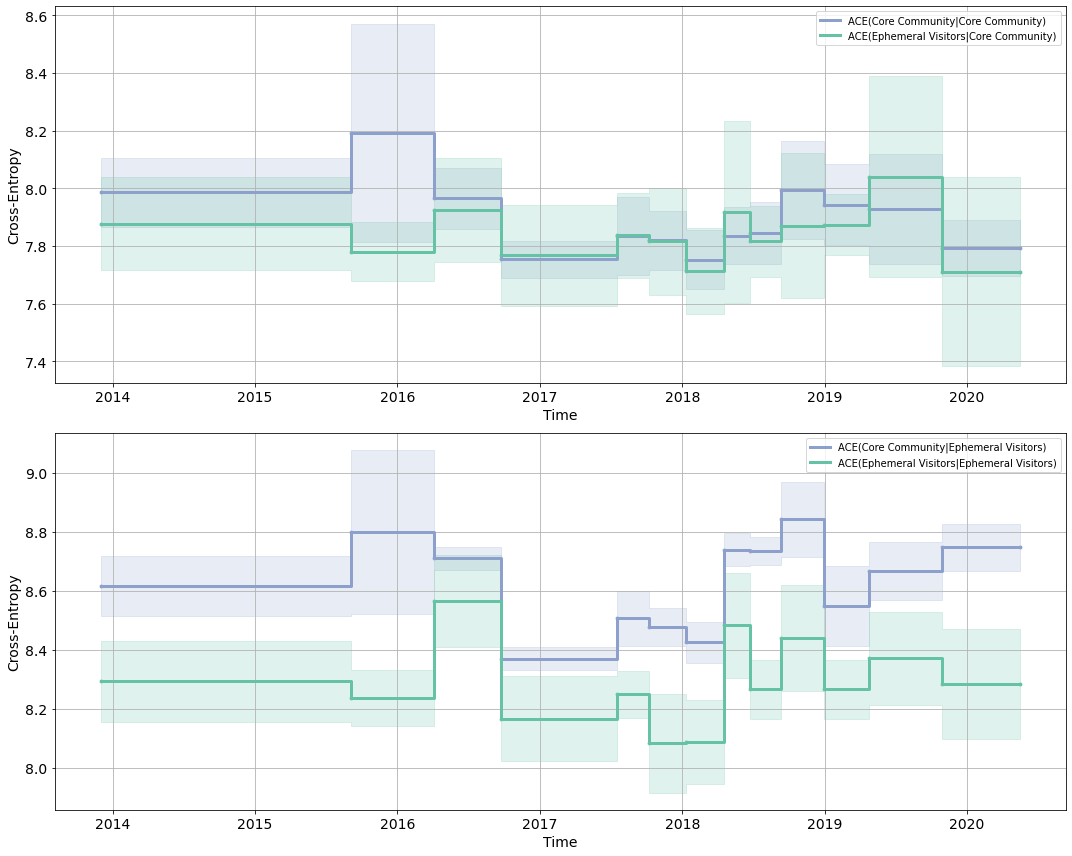

Wall time: 556 ms


In [29]:
%%time
fig, axes = plt.subplots(len(groups), figsize=(15, 6*len(groups)))
# fig.subplots_adjust(hspace=0.05, wspace=0)

for i, group1 in enumerate(groups):
    for group2 in groups:
        ace_runs = get_CE_means_fixed_windows(comparisons, group1, group2)
        ace_means, ace_stds = get_ce_mean_and_std(comparisons, group1, group2)

        plot_group_similarity_across_runs_stepped(ace_means, ace_stds, 
                                              axes[i], colour=clust_colours[group2], label=f'ACE({group2}|{group1})', 
                                              fill_alpha=0.2, end_dates=end_dates)

    axes[i].grid()
    axes[i].set_xlabel("Time", fontsize=14)
    axes[i].set_ylabel("Cross-Entropy", fontsize=14)
    plt.setp(axes[i].get_xticklabels(), fontsize=14, rotation=0)
    plt.setp(axes[i].get_yticklabels(), fontsize=14)
    
plt.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "Clust_ACE.pdf"))
plt.show()

### ACE - Unpredictability

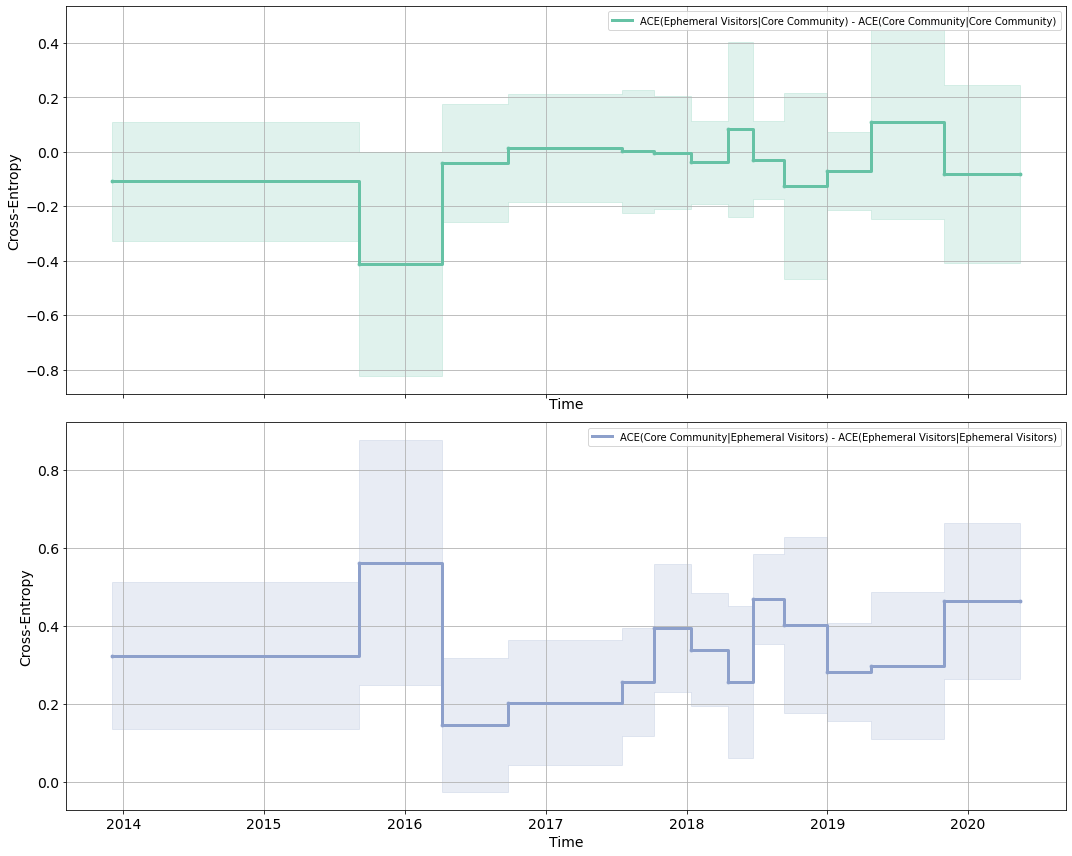

Wall time: 462 ms


In [30]:
%%time
fig, axes = plt.subplots(len(groups), figsize=(15, 6*len(groups)), sharex=True)

for i, group1 in enumerate(groups):

    unpredictability_runs = get_CE_means_fixed_windows(comparisons, group1, group1)
    
    for group2 in groups:
        if group1 == group2:
            continue
        
        ace_runs = get_CE_means_fixed_windows(comparisons, group1, group2)
        
        diff = ace_runs - unpredictability_runs
        
        means = diff.mean(axis=1)
        stds = diff.std(axis=1)

        plot_group_similarity_across_runs_stepped(means, stds, 
                                              axes[i], colour=clust_colours[group2], label=f'ACE({group2}|{group1}) - ACE({group1}|{group1})', 
                                              fill_alpha=0.2, end_dates=end_dates)

    axes[i].grid()
    axes[i].set_xlabel("Time", fontsize=14)
    axes[i].set_ylabel("Cross-Entropy", fontsize=14)
    plt.setp(axes[i].get_xticklabels(), fontsize=14, rotation=0)
    plt.setp(axes[i].get_yticklabels(), fontsize=14)
    
plt.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "Clust_ACE_diff.pdf"))
plt.show()

## Running it again with balanced groups

Now we've looked at them a bit more, we will look at the ACE of the two groups over time, compared to both the general forum, and each other.

In [31]:
ACE_FP = os.path.join(DATA_DIR, "Misc", "ace_metagroups_bal.json")

In [32]:
comparisons = get_CE_comparisons(ACE_FP)
end_dates = get_ends_of_windows(ACE_FP)
groups = list(comparisons[0].keys())

### Unpredictability of each group

First we will look at the unpredictability of each group.

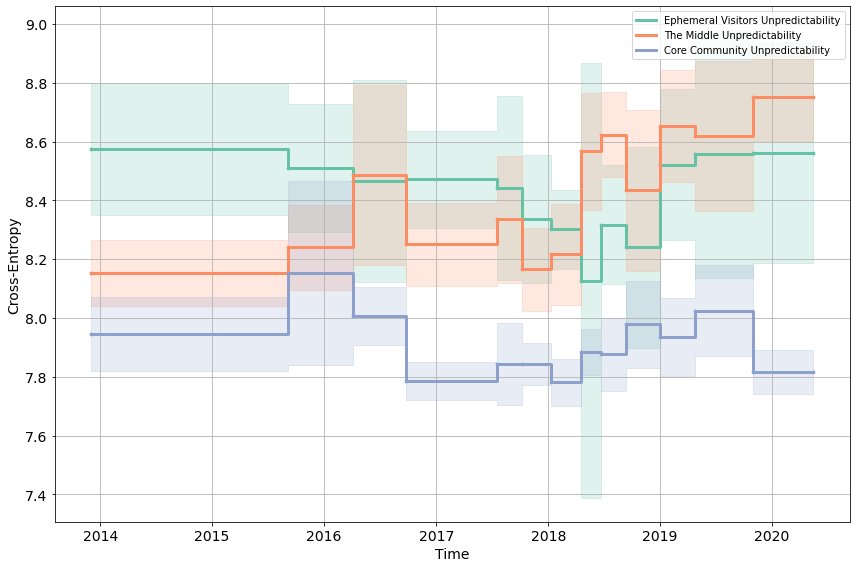

Wall time: 284 ms


In [33]:
%%time
fig, ax = plt.subplots(figsize=(12, 8))
fig.subplots_adjust(hspace=0, wspace=0)

for group in groups:
    unpredictability_runs = get_CE_means_fixed_windows(comparisons, group, group)
    unpredictability_means, unpredictability_stds = get_ce_mean_and_std(comparisons, group, group)
    
    plot_group_similarity_across_runs_stepped(unpredictability_means, unpredictability_stds, 
                                          ax, colour=clust_colours[group], label=f'{group} Unpredictability', 
                                          fill_alpha=0.2, end_dates=end_dates)
    
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Cross-Entropy", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14, rotation=0)
plt.setp(ax.get_yticklabels(), fontsize=14)

ax.grid()
plt.tight_layout()
# fig.savefig(os.path.join(OUT_DIR, "Clust_Unpredictability.pdf"))
plt.show()

### Comparisons Between Groups

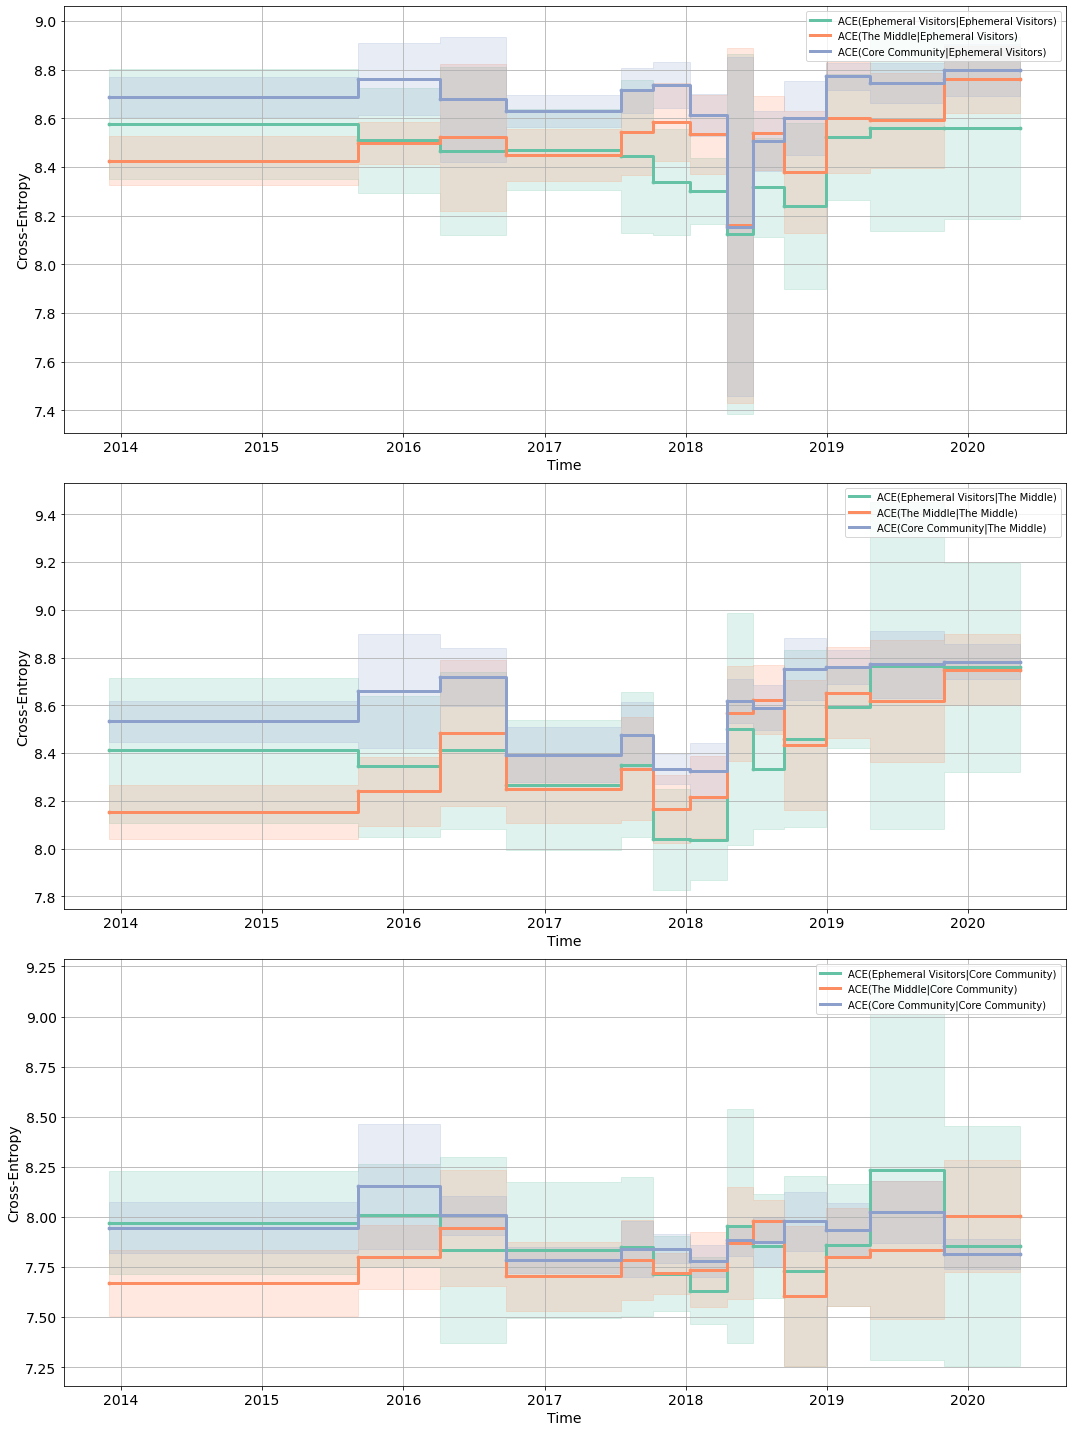

Wall time: 783 ms


In [34]:
%%time
fig, axes = plt.subplots(3, figsize=(15, 20))
# fig.subplots_adjust(hspace=0.05, wspace=0)

for i, group1 in enumerate(groups):
    for group2 in groups:
        ace_runs = get_CE_means_fixed_windows(comparisons, group1, group2)
        ace_means, ace_stds = get_ce_mean_and_std(comparisons, group1, group2)

        plot_group_similarity_across_runs_stepped(ace_means, ace_stds, 
                                              axes[i], colour=clust_colours[group2], label=f'ACE({group2}|{group1})', 
                                              fill_alpha=0.2, end_dates=end_dates)

    axes[i].grid()
    axes[i].set_xlabel("Time", fontsize=14)
    axes[i].set_ylabel("Cross-Entropy", fontsize=14)
    plt.setp(axes[i].get_xticklabels(), fontsize=14, rotation=0)
    plt.setp(axes[i].get_yticklabels(), fontsize=14)
    
plt.tight_layout()
# fig.savefig(os.path.join(OUT_DIR, "Clust_ACE.pdf"))
plt.show()

### ACE - Unpredictability

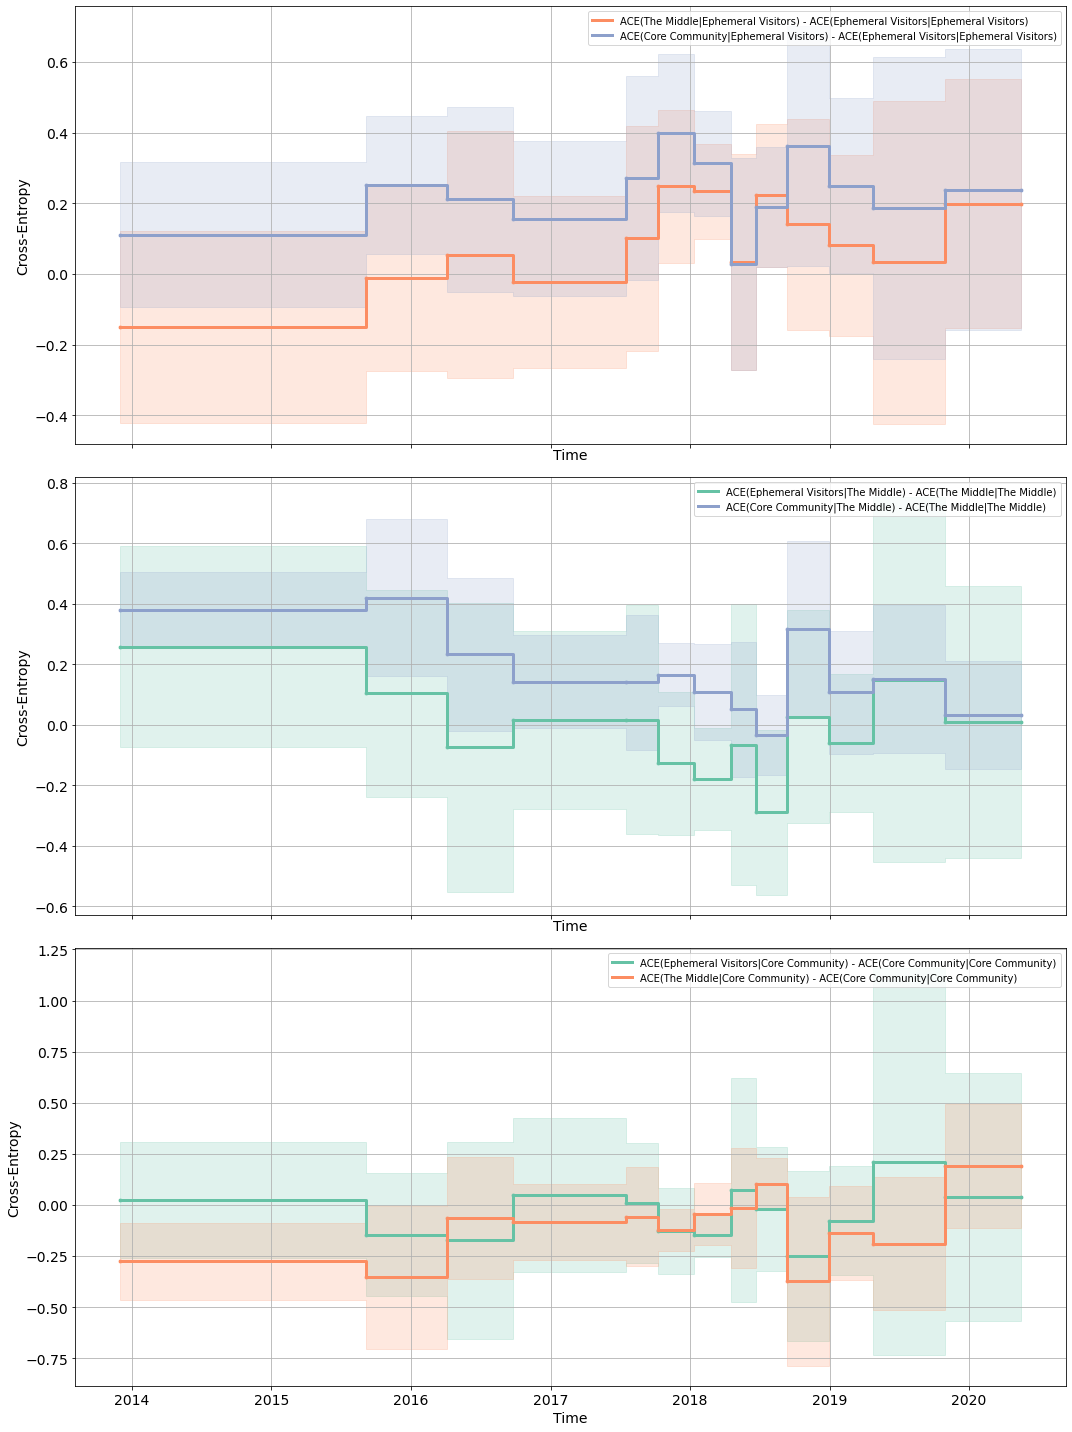

Wall time: 927 ms


In [35]:
%%time
fig, axes = plt.subplots(3, figsize=(15, 20), sharex=True)

for i, group1 in enumerate(groups):

    unpredictability_runs = get_CE_means_fixed_windows(comparisons, group1, group1)
    
    for group2 in groups:
        if group1 == group2:
            continue
        
        ace_runs = get_CE_means_fixed_windows(comparisons, group1, group2)
        
        diff = ace_runs - unpredictability_runs
        
        means = diff.mean(axis=1)
        stds = diff.std(axis=1)

        plot_group_similarity_across_runs_stepped(means, stds, 
                                              axes[i], colour=clust_colours[group2], label=f'ACE({group2}|{group1}) - ACE({group1}|{group1})', 
                                              fill_alpha=0.2, end_dates=end_dates)

    axes[i].grid()
    axes[i].set_xlabel("Time", fontsize=14)
    axes[i].set_ylabel("Cross-Entropy", fontsize=14)
    plt.setp(axes[i].get_xticklabels(), fontsize=14, rotation=0)
    plt.setp(axes[i].get_yticklabels(), fontsize=14)
    
plt.tight_layout()
# fig.savefig(os.path.join(OUT_DIR, "Clust_ACE_diff.pdf"))
plt.show()